<a href="https://colab.research.google.com/github/Thiagorcj/NLP_projects/blob/main/ProjetoNLP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP - Projeto Poet AI
### Autor: Thiago Rodrigues Cruz Justino
A ideia é gerar um poema atráves de textos de autores de livros ou arquivos pdf enviados pelo usuário.


### Bibliotecas usadas:

In [2]:
pip install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.6 MB/s eta 0:00:00


In [26]:
import random
import re
import PyPDF2
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
import nltk

### Função ``extract_text_from_pdf``
 Usada para extrair texto de um pdf, na ideia do app será enviado pelo usuário.
 O link do pdf utilizado(livro Iracema) está no seguinte link: https://github.com/Thiagorcj/NLP_projects/blob/main/livros/iracema.pdf


In [10]:

def extract_text_from_pdf(pdf_path):
    """
    Extrai o texto de um arquivo PDF.

    Args:
        pdf_path (str): Caminho do arquivo PDF.

    Returns:
        str: Texto extraído do PDF.
    """
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page_num in range(len(reader.pages)):
            page = reader.pages[page_num]
            text += page.extract_text()
        return text

text = extract_text_from_pdf('iracema.pdf')
print(text[1200:1600]) #Parte aleatória do livro

do poder criador. 
Os meninos brincam na sombra do outão, com pequenos ossos de reses, que figuram a 
boiada. Era assim que eu brincava, há quantos anos, em outro sítio, não mui distante do seu. A dona 
da casa, terna e incansável, manda abrir o coco verde, ou prepara o saboroso creme do buriti para 
refrigerar o esposo, que pouco há recolheu de sua excursão pelo sítio, e agora repousa embalandose


### Função ``extract_ngrams``
Extrai n-gramas de um texto dado.
Um n-grama é uma sequência 'n' itens de um texto. Nesta função,
os n-gramas são representados como tuplas de palavras. A função retorna um
dicionário onde as chaves são os n-gramas e os valores são as frequências
desses n-gramas no texto. Nesse caso, não calculei a probabilidade mais as
vezes que um n-grama aparece no texto, pareceu mais simples computacionalmente.

In [22]:
def extract_ngrams(text, n):
    """
    Extrai n-gramas de uma lista de palavras.

    Parâmetros:
    - text (list of str): Lista de palavras do texto.
    - n (int): O tamanho do n-grama (por exemplo, 2 para bigramas, 3 para trigramas).

    Retorno:
    - dict: Um dicionário com n-gramas como chaves e suas frequências como valores.
    """
    ngrams = {}
    for i in range(len(text) - n + 1):
        gram = tuple(text[i:i+n])
        if gram in ngrams:
            ngrams[gram] += 1
        else:
            ngrams[gram] = 1
    return ngrams

#### Função ``get_word_with_higuest_prob``
Retorna a palavra com a maior frenquência baseada nos ngrams dados como parâmetros.

In [23]:
def get_word_with_highest_prob(ngrams, context):
    """
    Retorna a palavra com a maior frequência baseada em um contexto fornecido.

    Parâmetros:
    - ngrams (dict): Um dicionário onde as chaves são tuplas representando n-gramas
                     e os valores são as frequências/probabilidades associadas a esses n-gramas.
    - context (tuple): Uma tupla representando o contexto (as palavras anteriores)
                       para o qual queremos encontrar a próxima palavra.

    Retorno:
    - str ou None: A palavra com a maior probabilidade de seguir o contexto dado,
                   ou None se não houver candidatos.
    """

    candidates = {k[-1]: v for k, v in ngrams.items() if k[:-1] == context}

    if not candidates:
        return None

    return max(candidates, key=candidates.get)

#### Função ``rhyme``
Verifica se duas palavras rimam, comparando as duas últimas letras de cada palavra.


In [24]:
def rhyme(word1, word2):
    """
    Verifica se duas palavras rimam, comparando as duas últimas letras de cada palavra.

    Parâmetros:
    - word1 (str): A primeira palavra a ser comparada.
    - word2 (str): A segunda palavra a ser comparada.

    Retorno:
    - bool: True se as duas palavras tiverem as duas últimas letras iguais, False caso contrário.
    """
    # Expressão regular para capturar as duas últimas letras de uma palavra
    pattern = r'.*(\w\w)$'

    # Extrai as duas últimas letras de cada palavra
    match1 = re.search(pattern, word1)
    match2 = re.search(pattern, word2)

    # Verifica se as duas últimas letras foram encontradas em ambas as palavras
    if match1 and match2:
        return match1.group(1) == match2.group(1)
    else:
        return False

#### Função ``generate_line``
Gera uma linha de texto começando com uma unica palavra, a ideia é utilizar bigrama, trigrama e quadrigrama, para cada palavra adicionada na linha é feito esse processo. Um detalhe é como queremos criar um rima então precisamos forçar rima em alguns casos.

In [25]:
def generate_line(bigrams, trigrams, quadrigrams, start_word, rhyme_word,stopwords):
    """
    Gera uma linha de texto começando com uma palavra inicial e tentando rimar com uma palavra final.

    Parâmetros:
    - bigrams (dict): Dicionário de bigramas onde as chaves são tuplas de palavras (contexto)
                      e os valores são as frequências/probabilidades associadas.
    - trigrams (dict): Dicionário de trigramas onde as chaves são tuplas de palavras (contexto)
                       e os valores são as frequências/probabilidades associadas.
    - quadrigrams (dict): Dicionário de quadrigramas onde as chaves são tuplas de palavras (contexto)
                          e os valores são as frequências/probabilidades associadas.
    - start_word (str): A palavra inicial para começar a linha.
    - rhyme_word (str): A palavra com a qual a linha deve tentar rimar.

    Retorno:
    - tuple: Uma tupla contendo a linha gerada (str) e a palavra final (str).
    """

    line = [start_word]  # Inicializa a linha com a palavra inicial

    for _ in range(3):  # Itera até 3 vezes para gerar a linha
        if len(line) == 1:
            # Se a linha tem 1 palavra, usa bigramas para encontrar a próxima palavra
            next_word = get_word_with_highest_prob(bigrams, (line[-1],))
        elif len(line) == 2:
            # Se a linha tem 2 palavras, usa trigramas para encontrar a próxima palavra
            next_word = get_word_with_highest_prob(trigrams, (line[-2], line[-1]))
        elif len(line) == 3:
            # Se a linha tem 3 palavras, usa quadrigramas para encontrar a próxima palavra
            next_word = get_word_with_highest_prob(quadrigrams, (line[-3], line[-2], line[-1]))

        if next_word:
            # Se encontrou a próxima palavra, adiciona à linha
            line.append(next_word)
        else:
            # Se não encontrou, interrompe a geração da linha
            break

    end_word = line[-1]  # Obtém a última palavra da linha gerada

    # Forçar rima se necessário
    if rhyme_word:
        # Encontra candidatos a rima usando bigramas
        rhyme_candidates = [k[-1] for k in bigrams.keys() if rhyme(k[-1], rhyme_word)]
        if rhyme_candidates:
            # Escolhe uma palavra candidata aleatoriamente e a define como a última palavra
            end_word = random.choice(rhyme_candidates)
            line[-1] = end_word

    # Verifica se a última palavra é uma stopword
    if end_word in stopwords:
        # Encontra candidatos que não sejam stopwords usando bigramas
        non_stopword_candidates = [k[-1] for k in bigrams.keys() if k[-1] not in stopwords]
        if non_stopword_candidates:
            # Escolhe uma palavra candidata aleatoriamente e a define como a última palavra
            end_word = random.choice(non_stopword_candidates)
            line[-1] = end_word

    return ' '.join(line), end_word  # Retorna a linha gerada como string e a última palavra

### Função ``generate_poem``
Gera um poema com um determinado número de linhas a partir de um texto dado e das funções antes mostradas.

In [20]:
def generate_poem(text, num_lines):
    """
    Gera um poema com um determinado número de linhas a partir de um texto dado.

    Parâmetros:
    - text (str): Texto base para gerar o poema.
    - num_lines (int): Número de linhas desejado para o poema.

    Retorno:
    - str: O poema gerado, com as linhas separadas por quebras de linha.
    """
    # Limpar e separar o texto em palavras com regex
    text = re.findall(r'\b\w+\b', text.lower())

    # Extrai bigramas, trigramas e quadrigramas do texto
    bigrams = extract_ngrams(text, 2)
    trigrams = extract_ngrams(text, 3)
    quadrigrams = extract_ngrams(text, 4)

    poem = []  # Lista para armazenar as linhas do poema
    previous_end_word = None  # Armazena a última palavra da linha anterior

    for i in range(num_lines):
        start_word = random.choice(text)  # Escolher aleatoriamente uma palavra inicial do texto

        if i % 2 == 0:
            # Alternar entre rima e não rima a cada duas linhas
            line, end_word = generate_line(bigrams, trigrams, quadrigrams, start_word, None)
        else:
            line, end_word = generate_line(bigrams, trigrams, quadrigrams, start_word, previous_end_word)

        poem.append(line)  # Adicionar a linha gerada ao poema
        previous_end_word = end_word  # Atualizar a última palavra para a próxima iteração

    return '\n'.join(poem)  # Retornar o poema como uma única string, com linhas separadas por quebras de linha

### Exemplo de uso:

In [33]:
text = extract_text_from_pdf('iracema.pdf')
num_lines = 15
poem = generate_poem(text, num_lines)
print(poem)

fazê las amadas esbelto
referia a si vulto
luz da manhã raiva
trilha já ouve cava
e o amigo uso
as margens do escasso
que o guerreiro branco
estrangeiro e hóspede branco
do guerreiro branco bonança
pai de jatobá esperança
onde a etiqueta manda
os guerreiros de rápida
ela não o deixaria
a virgem tabajara conversaria
de seu irmão sentada


### Extra:
Eu decidi com o objetivo de revisar o conceito e a ideia de Bag-of-words transformar o poema em uma matriz para visualizar na pratica como ficaria a matriz. Nesse caso eu utilizei cada linha como um documento diferente e todas palavras como o vocabulário

### Função ``create_bow_matrix``
Cria uma matriz Bag-of-Words a partir de um texto separado por linhas.

In [27]:
def create_bow_matrix(text_lines):
    """
    Cria uma matriz Bag-of-Words a partir de um texto separado por linhas.

    Parâmetros:
    - text_lines (list of str): Lista de linhas de texto (documentos) para gerar a matriz BoW.

    Retorno:
    - tuple: (Matriz BoW (numpy array), vocabulário (list of str))
    """
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text_lines)
    bow_matrix = X.toarray()
    vocabulary = vectorizer.get_feature_names_out()
    return bow_matrix, vocabulary

### Função ``plot_bow_matrix``
Plota a matriz Bag-of-Words como um heatmap.

In [29]:
def plot_bow_matrix(bow_matrix, vocabulary):
    """
    Plota a matriz Bag-of-Words como um heatmap.

    Parâmetros:
    - bow_matrix (numpy array): Matriz Bag-of-Words.
    - vocabulary (list of str): Lista de palavras do vocabulário.
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(bow_matrix, annot=True, cmap="YlGnBu", xticklabels=vocabulary, yticklabels=[f"Line {i+1}" for i in range(bow_matrix.shape[0])])
    plt.xlabel("Palavras")
    plt.ylabel("Linhas")
    plt.title("Matriz Bag-of-Words")
    plt.xticks(rotation=45, ha='right')
    plt.show()


### Função ``process_and_plot_text``
Processa o texto para criar e visualizar a matriz Bag-of-Words.

In [30]:
def process_and_plot_text(text):
    """
    Processa o texto para criar e visualizar a matriz Bag-of-Words.

    Parâmetros:
    - text (str): Texto a ser processado, com cada linha representando um documento separado.
    """
    # Dividir o texto em linhas
    text_lines = text.strip().split('\n')

    # Criar a matriz BoW
    bow_matrix, vocabulary = create_bow_matrix(text_lines)

    # Plotar a matriz BoW
    plot_bow_matrix(bow_matrix, vocabulary)


### Exemplo de uso:

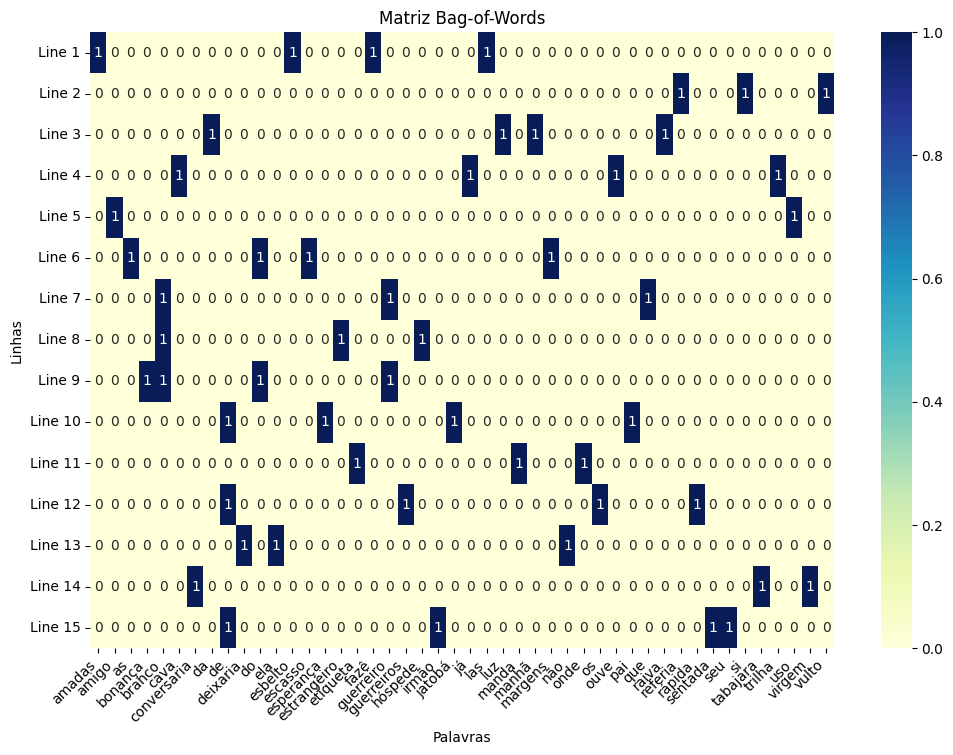

In [34]:
process_and_plot_text(poem)